In [50]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.07855   Mean   :0.3227      Mean   :0.2987           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :6.18826   Max.   :6.2046      Max.   :6.2005           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 11.24      Mean   :0.8927   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [51]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

[1] 12308


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.2879    Mean   :1.9290      Mean   :1.7916           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :6.1883    Max.   :6.2046      Max.   :6.2005           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  1.266     Min.   :0.000   Min.   :0                     
 1st Qu.: 37.500     1st Qu.:1.099   1st Qu.:0                     
 Median : 60.000     Median :1.609   Median :0                     
 Mean   : 58.871     Mean   :1.599   Mean   :0                     
 3rd Qu.: 80.000     3rd Qu.:2.197   3rd Qu.:0                     
 Max.   :100.000     Max.   :5.505   Max.   :0                     
    

# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [52]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(hasEffectiveComments)),]

combined <- rbind(sampledZerosdf, hasEffectiveComments)

hurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModel)
r.squaredGLMM(hurdleModel)
vif(hurdleModel)
anova(hurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + LanguageType + IsAfter, family = "binomial", 
    data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8708  -0.2191  -0.0048   0.2609   2.5974  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.92565    0.27402 -17.976  < 2e-16 ***
Additions                     -0.03559    0.02110  -1.687 0.091635 .  
Deletions                     -0.15955    0.02036  -7.837 4.60e-15 ***
IsMergedTrue                   0.59786    0.06776   8.823  < 2e-16 ***
Commits                       -0.61912    0.06606  -9.372  < 2e-16 ***
Assignees                      0.19157    0.11956   1.602 0.109

R2m       R2c 
0.8540752 0.8540752

,GVIF,Df,GVIF^(1/(2*Df))
Additions,3.196229,1,1.787800
Deletions,2.503296,1,1.582181
IsMerged,1.127854,1,1.062005
Commits,2.400032,1,1.549204
Assignees,1.026472,1,1.013149
ChangedFiles,3.563723,1,1.887783
NumOfUniqueUsers,2.744826,1,1.656752
PRsOpened,2.803635,1,1.674406
TotalBuilds,3.346564,1,1.829362
NewContributor,1.661454,1,1.288974


,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,24615,34125.02
Additions,1,2687.2410097,24614,31437.78
Deletions,1,152.4080236,24613,31285.37
IsMerged,1,12.3292021,24612,31273.04
Commits,1,5277.1685315,24611,25995.88
Assignees,1,121.4156316,24610,25874.46
ChangedFiles,1,135.4020263,24609,25739.06
NumOfUniqueUsers,1,5257.5954896,24608,20481.46
PRsOpened,1,0.2653231,24607,20481.20
TotalBuilds,1,330.3022882,24606,20150.89


In [53]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [54]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.33197 -0.23026  0.03586  0.25705  2.14956 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.294155   0.045152   6.515 7.57e-11 ***
Additions                      0.019592   0.003262   6.007 1.95e-09 ***
Deletions                     -0.054252   0.002902 -18.692  < 2e-16 ***
IsMergedTrue                   0.022167   0.011029   2.010 0.044470 *  
Assignees                     -0.061263   0.017150  -3.572 0.000355 ***
ChangedFiles                   0.011627   0.006971   1.668 0.095357 .  
NumOfUniqueUsers              -0.069314   0.015591  -4.446 8.84e-06 ***
PRsOpened                     -0.009836   0.003429  -2.869 0.004129 ** 
TotalBuilds                    0.085132   0.007090  12.006  < 2e-16 ***
NewContributorTrue            -0.011578   0.015737  -0.736 0.461906    
PrOpenedDaysAfterProjectStart  0.005768   0.006

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [55]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3221 -0.2290  0.0366  0.2565  2.1357 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.292937   0.045125   6.492 8.81e-11 ***
Additions                      0.019576   0.003259   6.006 1.96e-09 ***
Deletions                     -0.053758   0.002903 -18.518  < 2e-16 ***
IsMergedTrue                   0.021252   0.011051   1.923 0.054499 .  
Assignees                     -0.062093   0.017141  -3.623 0.000293 ***
ChangedFiles                   0.013161   0.006980   1.885 0.059390 .  
NumOfUniqueUsers              -0.070952   0.015605  -4.547 5.50e-06 ***
PRsOpened                     -0.008361   0.003447  -2.426 0.015289 *  
TotalBuilds                    0.082953   0.007106  11.673  < 2e-16 ***
NewContributorTrue            -0.010378   0.015730  -0.660 0.509423    
PrOpenedDaysAfterProjectStart  0.005852   0.006281   0.93

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.30835 -0.23883  0.04129  0.26597  2.14545 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.310275   0.049688   6.244 4.42e-10 ***
Additions                       0.018475   0.003667   5.038 4.77e-07 ***
Deletions                      -0.054229   0.003221 -16.834  < 2e-16 ***
IsMergedTrue                    0.014054   0.012093   1.162 0.245172    
Assignees                      -0.063487   0.018980  -3.345 0.000826 ***
ChangedFiles                    0.017142   0.007804   2.196 0.028080 *  
NumOfUniqueUsers               -0.080142   0.017615  -4.550 5.44e-06 ***
PRsOpened                      -0.008300   0.003893  -2.132 0.033050 *  
TotalBuilds                     0.082934   0.007717  10.747  < 2e-16 ***
NewContributorTrue             -0.021033   0.017716  -1.187 0.235161    
PrOpenedDaysAfterProjectStart   0.00

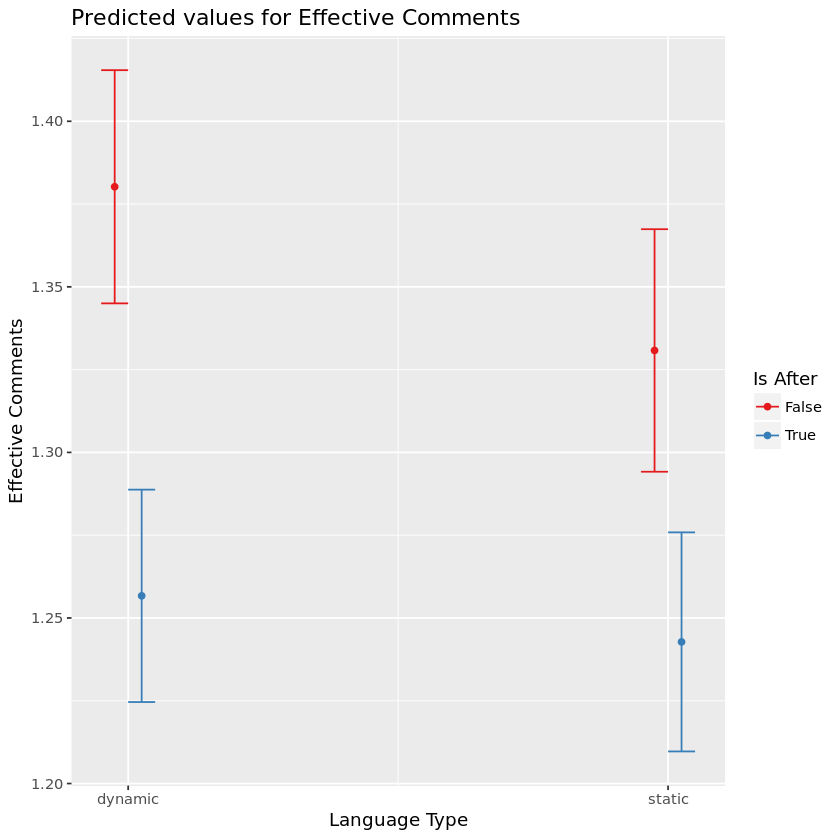

In [56]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('LanguageType', 'IsAfter'))

# Dynamic languages

In [57]:
dynModel <- executeLmOnData(
           EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'dynamic'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.05979 -0.23628  0.04385  0.26643  2.04050 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.069976   0.068232   1.026 0.305145    
Additions                      0.018393   0.005021   3.663 0.000251 ***
Deletions                     -0.058994   0.004397 -13.417  < 2e-16 ***
IsMergedTrue                   0.007251   0.015828   0.458 0.646897    
Commits                        0.065695   0.010712   6.133 9.22e-10 ***
Assignees                     -0.031642   0.026039  -1.215 0.224355    
ChangedFiles                   0.005399   0.011255   0.480 0.631484    
NumOfUniqueUsers              -0.010938   0.025486  -0.429 0.667821    
PRsOpened                     -0.006163   0.005541  -1.112 0.266048    
TotalBuilds                    0.047331   0.012509   3.784 0.000156 ***
NewContributorTrue            -0.006539   0.022

# Static languages

In [58]:
staticModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'static'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.24977 -0.25172  0.03456  0.25860  1.87803 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.374772   0.080242   4.671 3.09e-06 ***
Additions                      0.014224   0.005393   2.637  0.00838 ** 
Deletions                     -0.049628   0.004709 -10.538  < 2e-16 ***
IsMergedTrue                   0.036153   0.018807   1.922  0.05463 .  
Commits                        0.045749   0.010441   4.382 1.20e-05 ***
Assignees                     -0.069861   0.027810  -2.512  0.01203 *  
ChangedFiles                   0.009182   0.011201   0.820  0.41237    
NumOfUniqueUsers              -0.116061   0.024609  -4.716 2.47e-06 ***
PRsOpened                     -0.007956   0.005562  -1.431  0.15262    
TotalBuilds                    0.066419   0.011430   5.811 6.62e-09 ***
NewContributorTrue            -0.045654   0.029